# Unsupervised Learning: Clustering

In [1]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.arff import loadarff
from scipy.spatial.distance import cdist
import os
import copy
from random import sample

In [2]:
def normalize(data):
    df = copy.deepcopy(data)
    col_types = np.array(df.dtypes.astype(str).map({'float64':0, 'object':1}))
    for i in range(len(col_types)):
        if col_types[i] == 0:
            min = df.iloc[:,i].min()
            max = df.iloc[:,i].max()
            df.iloc[:,i] = (df.iloc[:,i]-min) / (max-min)
    return df

## HAC

In [3]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link='single'):
        self.link = link
        self.k = k
        
    def fit(self, x):
        self.init_clusters(x)
        while len(self.clusters) > self.k:
            self.combine_clusters()
        self.calc_metrics()

    def init_clusters(self, x):
        self.clusters = []
        nrows = x.shape[0]
        for i in range(nrows):
            self.clusters.append(x[i].reshape(1,-1))

    def combine_clusters(self):
        min_val = np.inf
        for i in range(len(self.clusters)):
            for j in range(len(self.clusters)):
                if i != j:
                    if self.link == 'complete':
                        temp = np.max(cdist(self.clusters[i], self.clusters[j]))
                    else:
                        temp = np.min(cdist(self.clusters[i], self.clusters[j]))
                    if temp < min_val:
                        i_1, i_2, min_val = i, j, temp
        self.clusters[i_1] = np.vstack((self.clusters[i_1], self.clusters[i_2]))
        del self.clusters[i_2]

    def calc_metrics(self):
        self.sse_vals = []
        self.total_sse = 0
        self.centroids = []
        for i in range(len(self.clusters)):
            centroid = np.mean(self.clusters[i], axis=0)
            self.centroids.append(centroid)
            sum_sq_dist = 0
            for j in range(len(self.clusters[i])):
                dist = np.linalg.norm(self.clusters[i][j]-centroid)
                sum_sq_dist += np.square(dist)
                self.total_sse += np.square(dist)
            self.sse_vals.append(sum_sq_dist)

    def print_clusters(self):
        np.set_printoptions(formatter={'float': lambda x: "{:.4f}".format(x)})
        print("Number of Clusters: {:d}".format(self.k))
        print("Total SSE: {:.4f}".format(self.total_sse))
        for i in range(len(self.clusters)):
            print('Cluster', i+1, 'Centroid:', self.centroids[i])
            print('Cluster', i+1, 'Length:', len(self.clusters[i]))
            print('Cluster', i+1, 'SSE: {:.4f}'.format(self.sse_vals[i]))

### 1.1.2 HAC Debug

In [4]:
abalone = np.array(normalize(pd.DataFrame(loadarff('datasets/abalone.arff')[0])))
abalone_hac = HACClustering(k=5, link='single')
abalone_hac.fit(abalone)
abalone_hac.print_clusters()

Number of Clusters: 5
Total SSE: 54.4392
Cluster 1 Centroid: [0.5990 0.5923 0.4915 0.2826 0.2682 0.2921 0.2316 0.3849]
Cluster 1 Length: 195
Cluster 1 SSE: 54.3917
Cluster 2 Centroid: [0.9189 0.9438 0.7105 0.7016 0.7590 0.7222 0.4472 0.8824]
Cluster 2 Length: 1
Cluster 2 SSE: 0.0000
Cluster 3 Centroid: [1.0000 0.9831 0.8026 0.8343 0.6575 0.7825 0.9221 0.8824]
Cluster 3 Length: 2
Cluster 3 SSE: 0.0475
Cluster 4 Centroid: [1.0000 0.9888 0.7895 1.0000 1.0000 0.8915 0.7186 0.5882]
Cluster 4 Length: 1
Cluster 4 SSE: 0.0000
Cluster 5 Centroid: [0.9189 0.9888 0.8684 0.7190 0.5797 0.7512 0.6432 0.9412]
Cluster 5 Length: 1
Cluster 5 SSE: 0.0000


### 1.1.3 HAC Eval

In [5]:
seismic = pd.DataFrame(loadarff('datasets/seismic-bumps_train.arff')[0])
seismic['Class'] = seismic['Class'].str.decode('utf8').astype('int')
seismic = np.array(normalize(seismic))

In [6]:
seismic_complete = HACClustering(k=5, link='single')
seismic_complete.fit(seismic)
seismic_complete.print_clusters()

Number of Clusters: 5
Total SSE: 22.4548
Cluster 1 Centroid: [0.3159 0.3648 0.5145 0.3490 0.3338 0.3077 0.2868 1.0000]
Cluster 1 Length: 67
Cluster 1 SSE: 10.0257
Cluster 2 Centroid: [0.2774 0.2597 1.0000 0.1224 0.4505 0.7549 0.1290 1.0000]
Cluster 2 Length: 1
Cluster 2 SSE: 0.0000
Cluster 3 Centroid: [0.3065 0.3333 0.6979 0.2792 0.3787 1.0000 0.2373 1.0000]
Cluster 3 Length: 1
Cluster 3 SSE: 0.0000
Cluster 4 Centroid: [0.0884 0.1818 0.0000 0.1450 0.1538 0.1245 0.0000 1.0000]
Cluster 4 Length: 1
Cluster 4 SSE: 0.0000
Cluster 5 Centroid: [0.7140 0.7588 0.5603 0.7028 0.6994 0.4864 0.7393 2.0000]
Cluster 5 Length: 70
Cluster 5 SSE: 12.4291


In [7]:
seismic_complete = HACClustering(k=5, link='complete')
seismic_complete.fit(seismic)
seismic_complete.print_clusters()

Number of Clusters: 5
Total SSE: 15.6967
Cluster 1 Centroid: [0.3636 0.4107 0.5609 0.3857 0.3937 0.2808 0.3155 1.0000]
Cluster 1 Length: 49
Cluster 1 SSE: 5.0209
Cluster 2 Centroid: [0.3471 0.3622 0.7897 0.2790 0.4410 0.8568 0.2234 1.0000]
Cluster 2 Length: 3
Cluster 2 SSE: 0.2178
Cluster 3 Centroid: [0.1656 0.2226 0.3509 0.2328 0.1520 0.3424 0.1918 1.0000]
Cluster 3 Length: 18
Cluster 3 SSE: 2.2794
Cluster 4 Centroid: [0.7918 0.8268 0.6060 0.7669 0.7787 0.4634 0.7877 2.0000]
Cluster 4 Length: 49
Cluster 4 SSE: 6.3712
Cluster 5 Centroid: [0.5326 0.6002 0.4536 0.5531 0.5144 0.5401 0.6266 2.0000]
Cluster 5 Length: 21
Cluster 5 SSE: 1.8075


## K-Means

In [8]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False):
        self.k = k
        self.debug = debug

    def fit(self, x):
        self.x = x
        self.init_centroids()
        self.cluster()
        self.calc_metrics()
        
    def init_centroids(self):
        self.centroids = []
        if self.debug:
            for i in range(self.k):
                self.centroids.append(self.x[i])
        else:
            indeces = sample(range(len(self.x)), self.k)
            for i in indeces:
                self.centroids.append(self.x[i])
        self.centroids = np.array(self.centroids)

    def cluster(self):
        centroid_change = np.inf
        while centroid_change != 0:
            self.mins = np.argmin(cdist(self.centroids, self.x),axis=0)
            new_centroids = np.zeros((self.k, self.x.shape[1]))
            self.clusters = []
            for i in range(self.k):
                rows = np.where(self.mins == i)
                d = self.x[rows,:]
                new_centroids[i] = np.mean(d,axis=1)
                self.clusters.append(d.squeeze())
            centroid_change = np.max(np.abs(self.centroids-new_centroids))
            self.centroids = copy.deepcopy(np.squeeze(new_centroids))

    def calc_metrics(self):
        self.sse_vals = []
        self.total_sse = 0
        for i in range(len(self.clusters)):
            sum_sq_dist = 0
            for j in range(len(self.clusters[i])):
                dist = np.linalg.norm(self.clusters[i][j]-self.centroids[i])
                sum_sq_dist += np.square(dist)
                self.total_sse += np.square(dist)
            self.sse_vals.append(sum_sq_dist)

    def print_clusters(self):
        np.set_printoptions(formatter={'float': lambda x: "{:.4f}".format(x)})
        print("Number of Clusters: {:d}".format(self.k))
        print("Total SSE: {:.4f}".format(self.total_sse))
        for i in range(len(self.clusters)):
            print('Cluster', i+1, 'Centroid:', self.centroids[i])
            print('Cluster', i+1, 'Length:', len(self.clusters[i]))
            print('Cluster', i+1, 'SSE: {:.4f}'.format(self.sse_vals[i]))

### K-Means Debug 

In [9]:
abalone = np.array(normalize(pd.DataFrame(loadarff('datasets/abalone.arff')[0])))
abalone_kmeans = KMEANSClustering(k=5,debug=True)
abalone_kmeans.fit(abalone)
abalone_kmeans.print_clusters()

Number of Clusters: 5
Total SSE: 9.7826
Cluster 1 Centroid: [0.7325 0.7327 0.6270 0.3817 0.3633 0.4045 0.3046 0.4839]
Cluster 1 Length: 75
Cluster 1 SSE: 4.0454
Cluster 2 Centroid: [0.3704 0.3519 0.2686 0.0926 0.0935 0.0940 0.0792 0.2180]
Cluster 2 Length: 34
Cluster 2 SSE: 0.6609
Cluster 3 Centroid: [0.9035 0.9050 0.7774 0.6579 0.5767 0.6193 0.5893 0.7279]
Cluster 3 Length: 24
Cluster 3 SSE: 3.2116
Cluster 4 Centroid: [0.5692 0.5628 0.4376 0.2110 0.2113 0.2248 0.1659 0.3170]
Cluster 4 Length: 54
Cluster 4 SSE: 1.5452
Cluster 5 Centroid: [0.1296 0.1037 0.1053 0.0177 0.0211 0.0272 0.0135 0.0724]
Cluster 5 Length: 13
Cluster 5 SSE: 0.3195


### K-Means Evaluation

In [10]:
seismic_kmeans = KMEANSClustering(k=5, debug=True)
seismic_kmeans.fit(seismic)
seismic_kmeans.print_clusters()

Number of Clusters: 5
Total SSE: 14.7279
Cluster 1 Centroid: [0.5349 0.6013 0.4617 0.5541 0.5232 0.5544 0.6248 2.0000]
Cluster 1 Length: 22
Cluster 1 SSE: 2.0160
Cluster 2 Centroid: [0.3684 0.4338 0.4356 0.4388 0.3573 0.2988 0.3673 1.0000]
Cluster 2 Length: 31
Cluster 2 SSE: 2.4076
Cluster 3 Centroid: [0.3658 0.3854 0.7563 0.3093 0.4659 0.3691 0.2413 1.0000]
Cluster 3 Length: 20
Cluster 3 SSE: 2.5248
Cluster 4 Centroid: [0.1634 0.2137 0.3968 0.2178 0.1555 0.3078 0.1775 1.0000]
Cluster 4 Length: 19
Cluster 4 SSE: 1.7770
Cluster 5 Centroid: [0.7961 0.8310 0.6054 0.7709 0.7802 0.4553 0.7919 2.0000]
Cluster 5 Length: 48
Cluster 5 SSE: 6.0025


In [11]:
iris = np.array(normalize(pd.DataFrame(loadarff('datasets/iris.arff')[0])))[:,0:-1].astype('float')
k_vals = range(2,8)

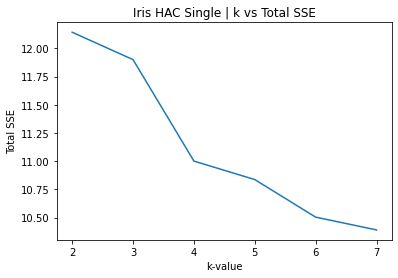

In [12]:
total_sse_scores = []
for i in k_vals:
    iris_hac_single = HACClustering(k=i, link='single')
    iris_hac_single.fit(iris)
    total_sse_scores.append(iris_hac_single.total_sse)

plt.plot(k_vals, total_sse_scores)
plt.title('Iris HAC Single | k vs Total SSE')
plt.xlabel('k-value')
plt.ylabel('Total SSE')
plt.show()

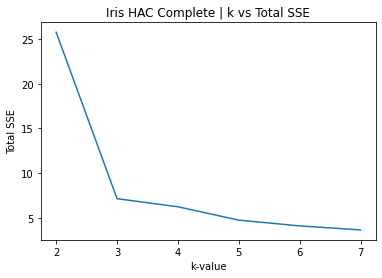

In [13]:
total_sse_scores = []
for i in k_vals:
    iris_hac_single = HACClustering(k=i, link='complete')
    iris_hac_single.fit(iris)
    total_sse_scores.append(iris_hac_single.total_sse)

plt.plot(k_vals, total_sse_scores)
plt.title('Iris HAC Complete | k vs Total SSE')
plt.xlabel('k-value')
plt.ylabel('Total SSE')
plt.show()

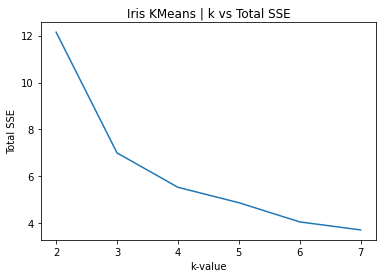

In [14]:
total_sse_scores = []
for i in k_vals:
    iris_kmeans = KMEANSClustering(k=i, debug=False)
    iris_kmeans.fit(iris)
    total_sse_scores.append(iris_kmeans.total_sse)

plt.plot(k_vals, total_sse_scores)
plt.title('Iris KMeans | k vs Total SSE')
plt.xlabel('k-value')
plt.ylabel('Total SSE')
plt.show()

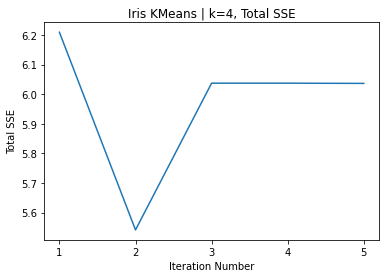

In [15]:
num_iterations = 5
total_sse_scores = []
for i in range(num_iterations):
    iris_kmeans = KMEANSClustering(k=4, debug=False)
    iris_kmeans.fit(iris)
    total_sse_scores.append(iris_kmeans.total_sse)

plt.plot(range(1,num_iterations+1), total_sse_scores)
plt.title('Iris KMeans | k=4, Total SSE')
plt.xlabel('Iteration Number')
plt.ylabel('Total SSE')
plt.xticks(range(1,6))
plt.show()

In [16]:
# Normalized Data
iris = np.array(normalize(pd.DataFrame(loadarff('datasets/iris.arff')[0])))[:,0:-1].astype('float')
bank = np.array(normalize(pd.DataFrame(loadarff('datasets/bank.arff')[0])))[:,0:-1].astype('float')
k_vals = range(2,8)

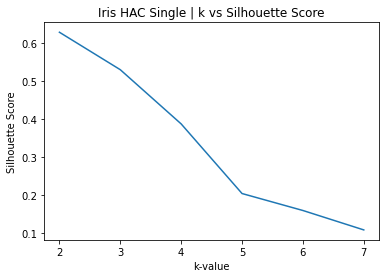

In [17]:
silhouette_scores = []
for i in k_vals:
    iris_hac = AgglomerativeClustering(n_clusters=i, linkage='single')
    labels = iris_hac.fit_predict(iris)
    score = silhouette_score(iris,labels)
    silhouette_scores.append(score)

plt.plot(k_vals, silhouette_scores)
plt.title('Iris HAC Single | k vs Silhouette Score')
plt.xlabel('k-value')
plt.ylabel('Silhouette Score')
plt.show()

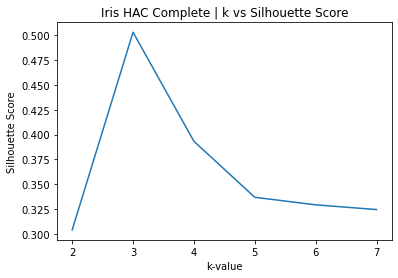

In [18]:
silhouette_scores = []
for i in k_vals:
    iris_hac = AgglomerativeClustering(n_clusters=i, linkage='complete')
    labels = iris_hac.fit_predict(iris)
    score = silhouette_score(iris,labels)
    silhouette_scores.append(score)

plt.plot(k_vals, silhouette_scores)
plt.title('Iris HAC Complete | k vs Silhouette Score')
plt.xlabel('k-value')
plt.ylabel('Silhouette Score')
plt.show()

## Iris K-Means -- SKLearn 

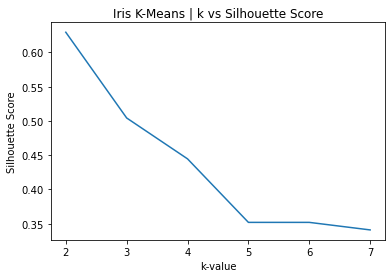

In [19]:
silhouette_scores = []
for i in k_vals:
    iris_kmeans = KMeans(n_clusters=i)
    labels = iris_kmeans.fit_predict(iris)
    score = silhouette_score(iris,labels)
    silhouette_scores.append(score)

plt.plot(k_vals, silhouette_scores)
plt.title('Iris K-Means | k vs Silhouette Score')
plt.xlabel('k-value')
plt.ylabel('Silhouette Score')
plt.show()

## Bank K-Means -- SKLearn 

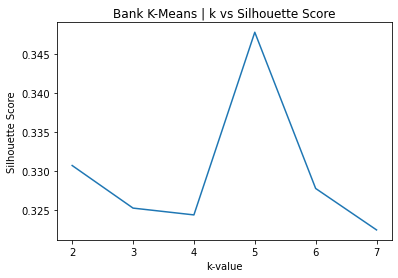

In [20]:
silhouette_scores = []
for i in k_vals:
    bank_kmeans = KMeans(n_clusters=i)
    labels = bank_kmeans.fit_predict(bank)
    score = silhouette_score(bank,labels)
    silhouette_scores.append(score)

plt.plot(k_vals, silhouette_scores)
plt.title('Bank K-Means | k vs Silhouette Score')
plt.xlabel('k-value')
plt.ylabel('Silhouette Score')
plt.show()

## Bank HAC -- SKLearn 

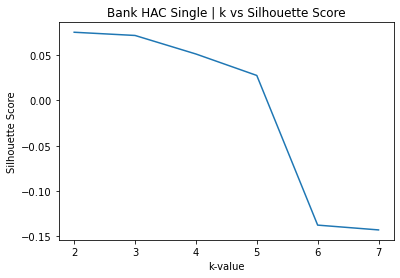

In [21]:
silhouette_scores = []
for i in k_vals:
    bank_hac = AgglomerativeClustering(n_clusters=i, linkage='single')
    labels = bank_hac.fit_predict(bank)
    score = silhouette_score(bank,labels)
    silhouette_scores.append(score)

plt.plot(k_vals, silhouette_scores)
plt.title('Bank HAC Single | k vs Silhouette Score')
plt.xlabel('k-value')
plt.ylabel('Silhouette Score')
plt.show()

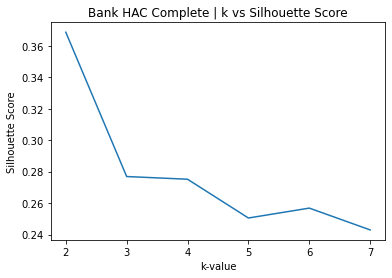

In [22]:
silhouette_scores = []
for i in k_vals:
    bank_hac = AgglomerativeClustering(n_clusters=i, linkage='complete')
    labels = bank_hac.fit_predict(bank)
    score = silhouette_score(bank,labels)
    silhouette_scores.append(score)

plt.plot(k_vals, silhouette_scores)
plt.title('Bank HAC Complete | k vs Silhouette Score')
plt.xlabel('k-value')
plt.ylabel('Silhouette Score')
plt.show()

In [23]:
hac1 = AgglomerativeClustering(n_clusters=5, linkage='complete')
labels = hac1.fit_predict(bank)
print('hac1 score:', silhouette_score(bank,labels))

hac2 = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='complete')
labels = hac2.fit_predict(bank)
print('hac2 score:', silhouette_score(bank,labels))

hac3 = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='single')
labels = hac3.fit_predict(bank)
print('hac3 score:', silhouette_score(bank,labels))

hac4 = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='average')
labels = hac4.fit_predict(bank)
print('hac4 score:', silhouette_score(bank,labels))

hac5 = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='complete')
labels = hac5.fit_predict(bank)
print('hac5 score:', silhouette_score(bank,labels))

hac1 score: 0.25050879502126383
hac2 score: 0.23445927520011628
hac3 score: -0.11769182294433174
hac4 score: 0.2618894243801878
hac5 score: 0.22950861153514115
